In [7]:
level = 'cntyvtd'
# level = 'tract'
district_type = 'cd'
proj_id = 'cmat-315920'
root_path = f'/home/jupyter'

import os, pathlib, google, numpy as np, pandas as pd, geopandas as gpd, matplotlib.pyplot as plt, plotly.express as px
from google.cloud import aiplatform, bigquery
try:
    from google.cloud.bigquery_storage import BigQueryReadClient
except:
    os.system('pip install --upgrade google-cloud-bigquery-storage')
    from google.cloud.bigquery_storage import BigQueryReadClient

cred, proj = google.auth.default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
bqclient   = bigquery.Client(credentials=cred, project=proj)
root_path  = pathlib.Path(root_path)
image_path = root_path / f'images/{district_type}/{level}'

tbl = f'{proj_id}.redistricting_data.cook_plans_TX_2020_{level}_{district_type}_stacked'
df = (bqclient.query(f'select * from {tbl}').result().to_dataframe()
      .drop(columns=[district_type])
      .rename(columns={'geoid':district_type})
     )
geo = gpd.GeoSeries.from_wkt(df['polygon'], crs='EPSG:4326').simplify(0.05).buffer(0)
gdf = gpd.GeoDataFrame(df, geometry=geo)
gdf['color'] = gdf['color'].astype(str)
gdf['locations'] = gdf.index


def make_images(animate=False, num_steps=1000000):
    num_steps = min(num_steps, df['plan'].max())
    if animate:
        opts['height'] = 1.13 * opts['width']
        X = gdf.query(f'plan <= {num_steps}')
        fig = px.choropleth_mapbox(X, geojson=X.geometry, **opts, animation_frame='plan', animation_group=X[district_type])
        fig.update_geos(fitbounds="locations", visible=False)
        fig.update(layout_showlegend=False)
        f = image_path / f'recomb_{district_type}_{level}.html'
        f.parent.mkdir(parents=True, exist_ok=True)
        fig.write_html(f, auto_play=True)
    else:
        opts['height'] = 0.97 * opts['width']
        for k in range(num_steps+1):
            print(k)
            X = gdf.query(f'plan == {k}')
            fig = px.choropleth_mapbox(X, geojson=X.geometry, **opts)
            fig.update_geos(fitbounds="locations", visible=False)
            fig.update(layout_showlegend=False)
            dig = len(str(num_steps))
            for ext in ['svg', 'eps', 'png', 'html']:
                f = image_path / f'{ext}/recomb_{district_type}_{level}_{str(k).rjust(dig,"0")}.{ext}'
                f.parent.mkdir(parents=True, exist_ok=True)
                if ext == 'html':
                    fig.write_html(f)
                else:
                    fig.write_image(f)
    return fig

opts = {
    'locations' : 'locations',
    'color' : "color",
    'color_discrete_sequence' : px.colors.qualitative.T10,
    'mapbox_style' : 'carto-positron',
    'opacity' : .4,
    'center' : {'lon': -100.05, 'lat': 31.0},
    'hover_data' : {'color':False,
                    'plan': False,
                    'locations':False,
                    'cd': True,
                    'total_pop': True,
                    'polsby_popper': True
                   }
}

0


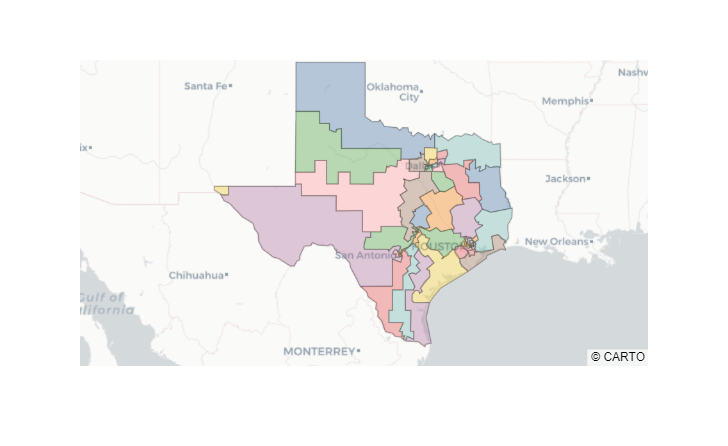

In [8]:
# opts['zoom'] = 3.0; opts['width'] = 310
opts['zoom'] = 4.0; opts['width'] = 460
# opts['zoom'] = 5.0; opts['width'] = 760

fig = make_images(animate=False, num_steps=0)
fig.show()
# fig = make_images(animate=True, num_steps=2)
# fig.show()